# Counterfeit detection

The task in this assignment is to detect the  counterfeit banknotes. The data set is based on [banknote authentication Data Set ](https://archive.ics.uci.edu/ml/datasets/banknote+authentication#) from UCI Machine Learning repository. The first three columns denote different parameters obtained from the photographs of the banknotes and last colum provides the label. Frankly as the dataset does not have any description I don't know  which labels corresponds to real and which to counterfeited banknotes. let's assume that label one (positive) denotes the clounterfeits. The set  "banknote_authentication.csv" can be found in the data  directory.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as st
import scrapbook as sb
import sys
sys.path.append('../..')

C:\Users\robi2\anaconda3\envs\machinelearning\lib\site-packages\papermill\iorw.py:50: FutureWarning: pyarrow.HadoopFileSystem is deprecated as of 2.0.0, please use pyarrow.fs.HadoopFileSystem instead.
  from pyarrow import HadoopFileSystem


In [2]:
sb.glue('person1',['Mikolaj', 'Mentel'], display=True)
# In case of the two-person team add second persons
sb.glue('person2',['Zuzanna', 'Miarzynska'])

['Mikolaj', 'Mentel']

In [3]:
data = pd.read_csv('data/banknote_authentication.csv')

In [4]:
data.head()

,a1,a2,a3,counterfeit
0,12.3784,0.70403,-7.58360,0
1,8.1881,-3.13380,-2.52760,0
2,-10.8679,9.49260,-1.41160,1
3,-8.7903,7.97350,-0.45475,1
4,-5.5167,10.93900,-0.40820,1


## Problem 

### A.

Perform the Quadratic Discriminant Analysis on this set. Calculate the confusion matrix, AUC score and plot the ROC curve. Please use `scrapbook` to store your results. 

In [5]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, precision_score, f1_score, confusion_matrix

In [6]:
seed = 432345
data_train, data_test = train_test_split(data,test_size=0.2, stratify = data['counterfeit'], random_state = seed)

qda = QuadraticDiscriminantAnalysis()
qda.fit(data_train.loc[:,'a1':'a3'], data_train['counterfeit'])

QuadraticDiscriminantAnalysis()

In [7]:
test_proba = qda.predict_proba(data_test.loc[:,'a1':'a3'])[:,1]

In [8]:
tnr, fpr, fnr, tpr = confusion_matrix(data_test['counterfeit'], test_proba>0.5,normalize = 'true').ravel()

In [9]:
f1 = f1_score(data_test['counterfeit'], test_proba>0.5)
precision = precision_score(data_test['counterfeit'], test_proba>0.5)

In [10]:
auc = roc_auc_score(data_test['counterfeit'], test_proba)
fprs, tprs, thds = roc_curve(data_test['counterfeit'], test_proba)

In [11]:
#sb.glue('A_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

In [12]:
sb.glue('A_scores',[tnr, fpr, fnr, tpr, precision, f1, auc], display=True)

[0.8278688524590164,
 0.1721311475409836,
 0.14285714285714285,
 0.8571428571428571,
 0.8,
 0.8275862068965518,
 0.9018066242890599]

also please save the ROC plot

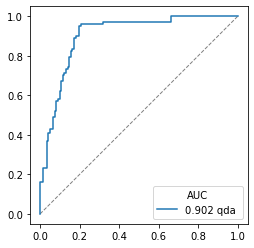

In [13]:
fig, ax = plt.subplots()
#plot ROC
ax.set_aspect(1)
ax.plot([0, 1], [0, 1], linewidth=1, linestyle='--', color='grey')
ax.plot(fprs, tprs, label="{1:5.3f} {0:s} ".format('qda', auc));
ax.legend(title='AUC');
sb.glue('A_ROC',fig, "display", display=False);

### B.

Perform Gaussian Mixture Discriminant Analysis on this set as described in the `gaussian_mixture_model_EM_algorithm` notebook. Use two components for positives and two components for negatives. Calculate the confusion matrix, AUC score and plot the ROC curve. 

In [14]:
from sklearn.mixture import GaussianMixture

In [15]:
real_train_data = data_train[data_train['counterfeit']==0]
counterfeit_train_data = data_train[data_train['counterfeit']==1]

In [16]:
len(counterfeit_train_data)/len(data_train)

0.44469783352337516

In [17]:
len(real_train_data)/len(data_train)

0.5553021664766249

In [18]:
gm_0 = GaussianMixture(n_components=2) 
gm_1 = GaussianMixture(n_components=2) 
print(real_train_data.loc[:,'a1':'a3'])

           a1        a2       a3
96    6.83690  0.697180 -0.55691
390  10.82230  2.643900 -4.83700
494   7.41010 -0.977090 -0.88406
664   6.14160  0.379290  0.56938
988   6.11890 -2.429400 -0.19613
..        ...       ...      ...
800  -0.15314  2.530000  2.44950
794   3.01490  0.228490 -0.14700
469  -0.46146  7.726700  0.90946
413   6.84100 -0.029423  0.44912
401   8.07640 -3.051500 -1.71550

[487 rows x 3 columns]


In [19]:
gm_0.fit(real_train_data.loc[:,'a1':'a3'])
gm_1.fit(counterfeit_train_data.loc[:,'a1':'a3'])

GaussianMixture(n_components=2)

In [20]:
def make_pdf(gm):
    """
    Takes a GaussianMixture object and returns corresponding
    probability distribution function
    """
    n_cmp = gm.n_components
    dists = [st.multivariate_normal(gm.means_[i], gm.covariances_[i]) for i in range(n_cmp)]
    def pdf(x):
        p = 0.0
        for i in range(n_cmp):
            p+= gm.weights_[i]*dists[i].pdf(x)
        return p
    
    return pdf
    
    
def make_predict_proba(gm_0, gm_1, pi0=0.5, pi1=0.5):
    """
    Takes two GaussianMixture object and corresponding priors and returns 
    pdf for conditional probability P(c=1|x)
    """
    pdf0 = make_pdf(gm_0)
    pdf1 = make_pdf(gm_1)
    def p(x):
        p0=pi0*pdf0(x)
        p1=pi1*pdf1(x)
        return p1/(p1+p0)    
        
    return p

In [21]:
gm_predict_proba = make_predict_proba(gm_0, gm_1, 0.56, 0.44)

In [22]:
gm_test_proba = gm_predict_proba(data_test.loc[:,'a1':'a3'])

In [23]:
gm_tnr, gm_fpr, gm_fnr, gm_tpr = confusion_matrix(data_test['counterfeit'], gm_test_proba>0.5,normalize = 'true').ravel()

In [24]:
gm_f1 = f1_score(data_test['counterfeit'], gm_test_proba>0.5)
gm_precision = precision_score(data_test['counterfeit'], gm_test_proba>0.5)

In [25]:
gm_auc = roc_auc_score(data_test['counterfeit'], gm_test_proba)
gm_fprs, gm_tprs, gm_thds = roc_curve(data_test['counterfeit'], gm_test_proba)

In [26]:
#sb.glue('B_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

In [27]:
sb.glue('B_scores',[gm_tnr, gm_fpr, gm_fnr, gm_tpr, gm_precision, gm_f1, gm_auc], display=True)

[0.9672131147540983,
 0.03278688524590164,
 0.12244897959183673,
 0.8775510204081632,
 0.9555555555555556,
 0.9148936170212767,
 0.9711441953830713]

also please save the ROC plot

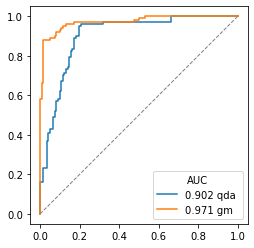

In [28]:
fig, ax = plt.subplots()
#plot ROC
ax.set_aspect(1)
ax.plot([0, 1], [0, 1], linewidth=1, linestyle='--', color='grey')
ax.plot(fprs, tprs, label="{1:5.3f} {0:s} ".format('qda', auc))
ax.plot(gm_fprs, gm_tprs, label="{1:5.3f} {0:s} ".format('gm', gm_auc))
ax.legend(title='AUC')
sb.glue('B_ROC',fig, "display", display=False)

### C.

Use k-fold cross validation to find the optimal number of gaussian components for each class. As before calculate the confusion matrix, AUC score and plot the ROC curve for the best classifier. 

__Hint__ use the `StratifiedKFold` function from scikit-learn library to generate folds. 

In [29]:
from sklearn.mixture import GaussianMixture

In [30]:
from sklearn.model_selection import StratifiedKFold

In [31]:
#  store the results of the best fit 
sb.glue("C_n_cmp",['n_cmp_pos', 'n_cmp_neg', 'best_f1_score'])

Store the results for the best estimator

In [32]:
sb.glue('C_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc']

also please save the ROC plot

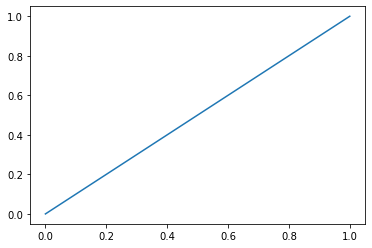

In [33]:
fig, ax = plt.subplots()
#plot ROCs (for A and B  Cproblems)
ax.plot([0,1],[0,1]);
sb.glue('C_ROC',fig, "display", display=False)

## D.  

Assume that 1% of all the customers in your store presents a counterfeit 100PLN bill. If you accept the counterfeit bill you loose 100PLN. If you reject a valid bill,  you may loose the purchase, you estimate this loss as 15PLN on average. For each of the three classifiers find the threshold that minimises your losses and calculates the minimum loss for each classifier. Show the optimal classifiers points on the ROC curves.

In [34]:
def score(fpr,fnr):
    fp_loss = fpr * 0.01 * 15
    fn_loss = fnr * 0.01 * 100
    return fp_loss+fn_loss

In [35]:
def find_optimal(fprs,tprs,thds):
    min_loss = 1
    index = 0
    for i in range(len(thds)):
            s=score(fprs[i], 1-tprs[i])
            if (s<min_loss):
                min_loss=s
                index=i
    tnr = 1 - fprs[index]
    fpr = fprs[index]
    fnr = 1 - tprs[index]
    tpr = tprs[index]
    threshold = thds[index]
    precision = precision_score(data_test['counterfeit'], test_proba>threshold)
    f1 = f1_score(data_test['counterfeit'], test_proba>threshold)
    auc = roc_auc_score(data_test['counterfeit'], test_proba)
    return tnr, fpr, fnr, tpr, precision, f1, auc, min_loss, threshold

In [36]:
tnr, fpr, fnr, tpr, precision, f1, auc, min_loss, threshold = find_optimal(fprs,tprs,thds)

In [37]:
#sb.glue('D_A_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

In [38]:
sb.glue('D_A_scores',[tnr, fpr, fnr, tpr, precision, f1, auc, min_loss, threshold], display=True)

[0.7950819672131147,
 0.20491803278688525,
 0.04081632653061229,
 0.9591836734693877,
 0.788135593220339,
 0.861111111111111,
 0.9018066242890599,
 0.07155403144864508,
 0.19160587499099996]

In [39]:
gm_tnr, gm_fpr, gm_fnr, gm_tpr, gm_precision, gm_f1, gm_auc, gm_min_loss, gm_threshold = find_optimal(gm_fprs,gm_tprs,gm_thds)

In [40]:
#sb.glue('D_B_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

In [41]:
sb.glue('D_B_scores',[gm_tnr, gm_fpr, gm_fnr, gm_tpr, gm_precision, gm_f1, gm_auc, gm_min_loss, gm_threshold], display=True)

[0.8278688524590164,
 0.1721311475409836,
 0.030612244897959218,
 0.9693877551020408,
 0.752,
 0.84304932735426,
 0.9018066242890599,
 0.056431917029106764,
 0.15605175630290147]

In [42]:
sb.glue('D_C_scores',['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold'], display=True)

['tnr', 'fpr', 'fnr', 'tpr', 'precision', 'f1', 'auc', 'min_loss', 'threshold']

also please save the ROC plot

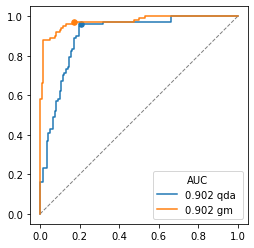

In [43]:
fig, ax = plt.subplots()
#plot ROCs
ax.set_aspect(1)
ax.plot([0, 1], [0, 1], linewidth=1, linestyle='--', color='grey')
ax.plot(fprs, tprs, label="{1:5.3f} {0:s} ".format('qda', auc))
ax.scatter([fpr],[tpr], s = 30)
ax.plot(gm_fprs, gm_tprs, label="{1:5.3f} {0:s} ".format('gm', gm_auc))
ax.scatter([ gm_fpr],[gm_tpr], s = 30)

ax.legend(title='AUC')
sb.glue('D_ROC',fig, "display", display=False)